In [45]:
import numpy as np
import matplotlib
import numpy as np
import scipy.stats as sst
import scipy as sp
import matplotlib.pylab as plt

import scipy.spatial.distance as ssp

In [56]:
A = np.random.randint(70, size=(50,50))
print (A)

[[15 13 18 ...  9 14 50]
 [38 65 60 ... 39 33 64]
 [ 6 36  6 ...  1 35  1]
 ...
 [37 10 51 ... 35 58 45]
 [14 25 21 ... 16 44 18]
 [48  4 13 ... 55 40 24]]


In [57]:
position_vector = np.random.randint(50, size=(150,2))
unique = np.unique(position_vector, axis=0)
data = [A[i[0], i[1]] for i in unique]
len_data = len(data)

(array([0.01735048, 0.01122678, 0.00816493, 0.01735048, 0.01122678,
        0.01530925, 0.01530925, 0.01632986, 0.01939171, 0.01326801]),
 array([ 0. ,  6.9, 13.8, 20.7, 27.6, 34.5, 41.4, 48.3, 55.2, 62.1, 69. ]),
 <a list of 10 Patch objects>)

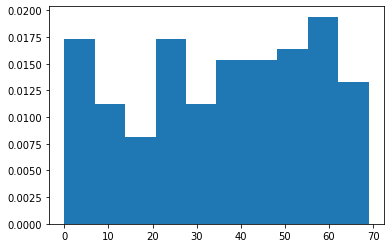

In [58]:
plt.hist(data, density=True)

(array([0.11971831, 0.1971831 , 0.25352113, 0.37323944, 0.45070423,
        0.55633803, 0.66197183, 0.77464789, 0.9084507 , 1.        ]),
 array([ 0. ,  6.9, 13.8, 20.7, 27.6, 34.5, 41.4, 48.3, 55.2, 62.1, 69. ]),
 <a list of 10 Patch objects>)

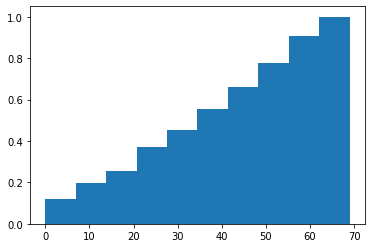

In [59]:
plt.hist(data, 
         density=True,
         cumulative=True)

In [60]:
coordinates_data = np.array([[i[0]*10, i[1]*10] for i in unique])


In [61]:
H = ssp.pdist(coordinates_data, metric='euclidean')
D = ssp.squareform(H)

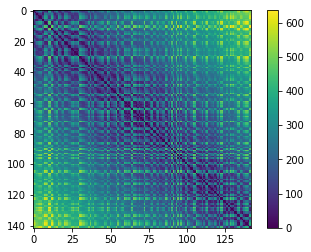

In [62]:
plt.imshow(D)
plt.colorbar()

Text(0.5, 1.0, 'Plan view')

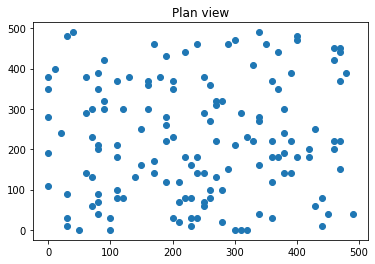

In [63]:
plt.scatter(coordinates_data[:,0], coordinates_data[:,1])
plt.title('Plan view')

In [64]:
var = np.zeros((len_data,len_data))
for i in range(len_data):
    for j in range(i, len_data):
        var[i,j] = (data[i] - data[j])**2.

Text(0, 0.5, 'variance')

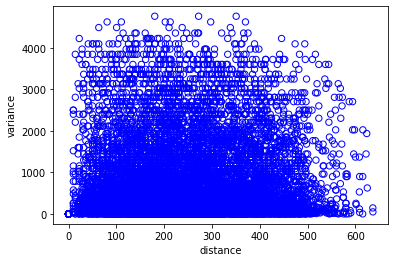

In [65]:
dists_ix = np.triu_indices(D.shape[0], 0)
dists_triu = D[dists_ix]

vars_ix = np.triu_indices(var.shape[0], 0)
vars_triu = var[vars_ix]

plt.scatter(dists_triu, vars_triu, s=40, facecolors='none', edgecolors='b')
plt.xlabel("distance")
plt.ylabel("variance")